In [4]:
import math
import string
import time
from functools import reduce

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import seed,random,randint
import plotly.express as px
from IPython.display import display
from pandas import DataFrame
from scipy.cluster import hierarchy
from scipy import stats
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler, StandardScaler

## Importing variety of time series

### Importing S&P 500 Daily time series

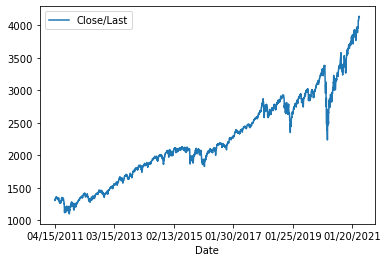

Length: 2560


In [5]:
spx_short = pd.read_csv('../data/spx_daily_11-21.csv', usecols=[0,1])
spx_short['Close/Last']=spx_short['Close/Last'].astype(int)
spx_short=spx_short.iloc[::-1]
spx_short.plot(x='Date', y='Close/Last')
plt.show()
np_spx_short = spx_short['Close/Last'].to_numpy()
print('Length: '+str(np_spx_short.shape[0]))

### Importing S&P 500 all time Monthly time series over 200 years

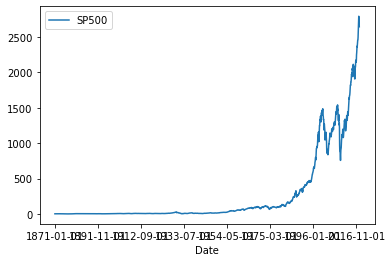

Length: 1768


In [6]:
spx_long = pd.read_csv('../data/spx_monthly_alltime.csv', usecols=[0,1])
spx_long.plot(x='Date', y='SP500')
plt.show()
np_spx_long = spx_long['SP500'].to_numpy()
print('Length: '+str(np_spx_long.shape[0]))

### Importing minimum temperature data set

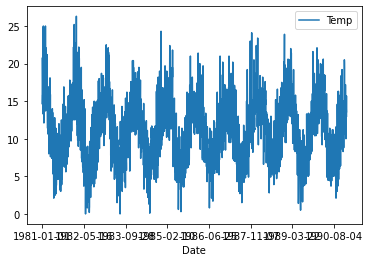

Length: 3650


In [7]:
min_daily_temp = pd.read_csv('../data/daily-minimum-temperatures-in-melbourne.csv',usecols=[0,1])
#min_daily_temp['Temp'] = min_daily_temp['Temp'].apply(pd.to_numeric,errors='coerce')
min_daily_temp.plot(x='Date', y='Temp')
plt.show()
np_min_daily_temp = min_daily_temp['Temp'].to_numpy()
print('Length: '+str(np_min_daily_temp.shape[0]))

### Importing german DAX alltime

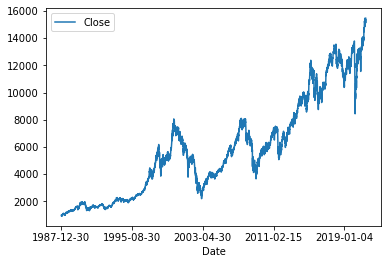

Length: 8602


In [10]:
dax_alltime = pd.read_csv('../data/dax_alltime.csv', usecols=[0,4])
dax_alltime.plot(x='Date', y='Close')
plt.show()
np_dax_alltime = dax_alltime['Close'].to_numpy()

for i in range(np_dax_alltime.shape[0]):
    if math.isnan(np_dax_alltime[i]):
        np_dax_alltime[i] = np_dax_alltime[i-1]

print('Length: '+str(np_dax_alltime.shape[0]))

### Importing Bitcoin alltime

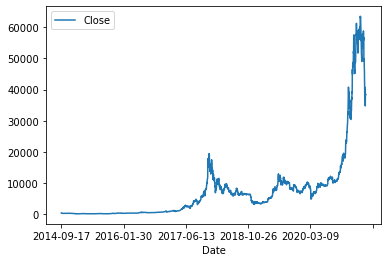

Length: 2444


In [11]:
bitcoin_alltime = pd.read_csv('../data/bitcoin_alltime.csv', usecols=[0,4])
bitcoin_alltime.plot(x='Date', y='Close')
plt.show()
np_bitcoin_alltime = bitcoin_alltime['Close'].to_numpy()

for i in range(np_bitcoin_alltime.shape[0]):
    if math.isnan(np_bitcoin_alltime[i]):
        np_bitcoin_alltime[i] = np_bitcoin_alltime[i-1]

print('Length: '+str(np_bitcoin_alltime.shape[0]))

### Importing hydraulic pressure Data Set

Length: 6000


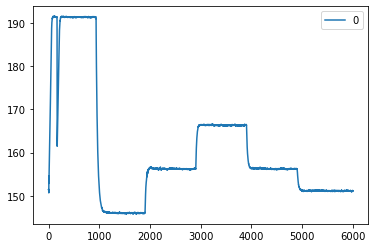

In [10]:
np_hydraulic = np.loadtxt('../data/PS1.txt',delimiter='\t')[0]
for i in range(np_hydraulic.shape[0]):
    if math.isnan(np_hydraulic[i]):
        np_hydraulic[i] =  np_hydraulic[i-1]

l = np_hydraulic.shape[0]
df_hydraulic = pd.DataFrame(np_hydraulic,np.arange(0,l))
df_hydraulic.plot()

print('Length: '+str(l))

### Importing Beijing O3 in air concentration (quality)

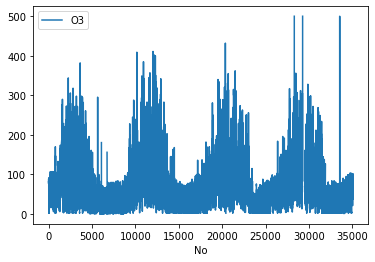

Length: 35064


In [11]:
air_quality = pd.read_csv('../data/PRSA_Data_Dingling_20130301-20170228.csv',usecols=[0,10])
air_quality.plot(x='No',y='O3')
plt.show()

np_air_quality = air_quality['O3'].to_numpy()
for i in range(np_air_quality.shape[0]):
    if math.isnan(np_air_quality[i]):
        np_air_quality[i] =  np_air_quality[i-1]

print('Length: '+str(np_air_quality.shape[0]))

## Time series preprocessing functions
Defining functions for creating random walk and extracting subsequences of time series.

In [12]:
def create_random_walk(ts: np.array, seed_=0):
    """
    Create same length random walk as times series.
    :param ts: time series to which length random walk should be equal (shape: [m])
    :return: random walk with same length to ts (shape: [m])
    """

    #seed(randint(mi,ma))
    seed(seed_)
    ma = np.ceil(np.amax(ts))
    mi = np.ceil(np.amin(ts))
    random_walk = list()

    random_walk.append(randint(mi,ma))
    for i in range(1, ts.shape[0]):
	    r = randint(0,10)
	    movement = r if random() < 0.5 else -r
	    value = random_walk[i-1] + movement
	    random_walk.append(value)

    return np.array(random_walk)

In [13]:
def to_sts_matrix(ts: np.array, w: int):
    """
    Create STS matrix of time series.
    :param ts: time series sts matrix should be created from (shape: [m])
    :param w: sliding window length
    :return: sts matrix (shape: [m-w+1,w])
    """
    shape = ts.shape[:-1] + (ts.shape[-1] - w + 1, w)
    strides = ts.strides + (ts.strides[-1],)
    return np.lib.stride_tricks.as_strided(ts, shape=shape, strides=strides)


def to_random_sampling_matrix(ts: np.array, w: int, reduced_sampling_size=False, seed_=0):
    """
    Create random sampling matrix for whole clustering by extracting random subsequences from ts.
    :param ts: time series random sampling matrix should be created from (shape: [m])
    :param w: sliding window length
    :param reduced_sampling_size: if true, random sampling matrix will have length m//w
        meaning haveing the same length as whole clustering matrix as in experiment 2 (much smaller)
    :return: random sampling matrix (shape: [m-w+1,w] or (shape: [m//w,w]))
    """
    m = ts.shape[0]
    num_samples = m//w if reduced_sampling_size else m - w + 1
    data_matrix = np.zeros((num_samples, w), dtype=int)

    seed(seed_)
    
    for i in range(num_samples):
        r = randint(0, m - w)
        for j in range(w):
            data_matrix[i][j] = ts[r+j]

    return data_matrix

## Defining Meaningfulness functions

Meaningfulness functions as defined by Keogh in his paper.

In [14]:
def cluster_distance(a: np.array, b: np.array, dist_metric_name: string):
    """
    Calculate distance between to sets of clusters (as defined by Keogh).
    :param a: cluster centres derived from one run of clustering algor (shape: [k,w])
    :param b: cluster centres derived from different run of clustering algor (shape: [k,w])
    :param dist_metric_name: name/tag of distance metric to be used for distance calculation
    :return: cluster distance
    """
    assert a.shape[1] != 0
    summ = 0
    n = a.shape[0]

    ## Using lambda functions to calculate distance
#     for i in range(n):
#         f = lambda x: distance_metric(a[i],x,dist_metric_name)
#         summ += np.amin(np.array(list(map(f,b))))
    
    ## Using imperative programming
    for i in range(n):
        minn = np.Inf
        for j in range(n):
            d = distance_metric(a[i],b[j],dist_metric_name)
            if d < minn:
                minn = d
        summ += minn       
    return summ


def within_set_distance(x: np.array, dist_metric_name: string):
    """
    Calculate the cluster distance within a set of clusters (as defined by Keogh).
    :param x: set of cluster centers derived with the same clustering method (shape: [n,k,w])
    :param dist_metric_name: name/tag of distance metric to be used for distance calculation
    :return: within set distance
    """
#     print(x.shape)
    n = x.shape[0]
    summ = 0
    for i in range(n):
        for j in range(n):
#             print(summ)
#             print(x[i])
            summ += cluster_distance(x[i], x[j], dist_metric_name)
    return summ/n**2


def between_set_distance(x: np.array, y: np.array, dist_metric_name: string):
    """
    Calculate the cluster distance between two sets of clusters (as defined by Keogh).
    :param x: set of cluster centers derived with the same clustering method (shape: [n,k,w])
    :param y: set of cluster centers derived with the same but different clustering method as x (shape: [n,k,w])
    :param dist_metric_name: name/tag of distance metric to be used for distance calculation
    :return: between set distance
    """
    n = x.shape[0]
    m = y.shape[0]
    summ = 0
    for i in range(n):
        for j in range(m):
            summ += cluster_distance(x[i], y[j], dist_metric_name)
    return summ/(n*m)


def clustering_meaningfulness(x: np.array, y: np.array, dist_metric_name: string):
    """
    Calculate cluster meaningfulness (as defined by Keogh)
    :param x: set of cluster centers derived with the same clustering method (shape: [n,k,w])
    :param y: set of cluster centers derived with the same but different clustering method as x (shape: [n,k,w])
    :param dist_metric_name: name/tag of distance metric to be used for distance calculation
    :return: clustering meaningfulness as a quotient ofwithin set distance of x and between set distance between x and y
    """
    wsd = within_set_distance(x,dist_metric_name)
    bsd = between_set_distance(x,y,dist_metric_name)
    
#     if bsd == 0:
#         print('XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX')
#     print('WSD: '+str(wsd)+'    BSD: '+str(bsd))
    return wsd/bsd

The experimental process of calculating the sts and whole meaningfulness for a set of k, w and r regarding one time series and an opposing time series.

In [15]:
def calculate_meaningfulness(target_ts: np.array, opposing_ts: np.array, n: int, k: int, w: int, r: int, normalizer: string,
                             dist_metric_name: string, cluster_algor_name: string, reduced_sampling_size: bool,
                             dim_red: bool, unify: bool, seed_):
    """
    Calculating sts and whole meaningfulness for 2 given time series where ts is the time series in regard.
    :param ts: time series in regard (shape: [m])
    :param opposing_ts: opposing time series (e.g. random walk) (shape: [m']) where m' not necessatily equal to m
    :param n: amount of meaningfulness calculations to be averaged over
    :param k: amount of centroids to be calculated
    :param w: sliding window size
    :param r: size of sets for between/within set distance
    :param normalizer: name/tag of normalizer to be used
    :param reduced_sampling_size: if true, sampling size for whole clustering will be reduced
    :param dist_metric_name: name/tag of distance metric to be used
    :param cluster_algor_name: name/tag of clustering algorithm to be used
    :param dim_red: if true, pca will be calculated on feature matrix for w>8
    :param seed_: seed for random sampling matrix
    :return: sts meaningfulness, whole meaningfulness
    """
    meaningfulness_sts = 0
    meaningfulness_whole = 0

    sts_target_matrix = to_sts_matrix(target_ts, w)
    sts_target_matrix = scale_feature_matrix(sts_target_matrix, normalizer)

    sts_opposing_matrix = to_sts_matrix(opposing_ts, w)
    sts_opposing_matrix = scale_feature_matrix(sts_opposing_matrix, normalizer)
    
    whole_target_matrix = to_random_sampling_matrix(target_ts, w, reduced_sampling_size, seed_)
    whole_target_matrix = scale_feature_matrix(whole_target_matrix, normalizer)

    whole_opposing_matrix = to_random_sampling_matrix(opposing_ts, w, reduced_sampling_size, seed_)
    whole_opposing_matrix = scale_feature_matrix(whole_opposing_matrix, normalizer)

    #pca
    if dim_red & w>8:
        sts_target_matrix = PCA(n_components='mle').fit_transform(sts_ts_matrix)
        whole_target_matrix = PCA(n_components='mle').fit_transform(whole_ts_matrix)
        sts_opposing_matrix = PCA(n_components='mle').fit_transform(sts_opposing_matrix)
        whole_opposing_matrix = PCA(n_components='mle').fit_transform(whole_opposing_matrix)

    for _ in range(n):
        sts_target_centers = np.zeros((r,k,w))
        whole_target_centers = np.zeros((r,k,w))
        sts_opposing_centers = np.zeros((r,k,w))
        whole_opposing_centers = np.zeros((r,k,w))

        for i in range(r):
            sts_target_centers[i] = cluster_functions(sts_target_matrix,k,cluster_algor_name,unify)
            whole_target_centers[i] = cluster_functions(whole_target_matrix,k,cluster_algor_name,unify)
            sts_opposing_centers[i] = cluster_functions(sts_opposing_matrix,k,cluster_algor_name,unify)
            whole_opposing_centers[i] = cluster_functions(whole_opposing_matrix,k,cluster_algor_name,unify)

        meaningfulness_sts += clustering_meaningfulness(sts_target_centers, sts_opposing_centers, dist_metric_name)
        meaningfulness_whole += clustering_meaningfulness(whole_target_centers, whole_opposing_centers, dist_metric_name)

    return meaningfulness_sts/n, meaningfulness_whole/n

### Defining helper functions 

In [16]:
def distance_metric(v: np.array, w: np.array, metric_name='eukl'):
    """
    Calculates distance between v and w accodring to passed metric.
    :param v: vector (shape: [m])
    :param w: vector (shape: [m])
    :param metric_name: name/tag of distance metric to be used for calculation.
    :return: distance between v and w
    """
    if metric_name == 'eukl':
        return np.linalg.norm(v-w)

In [17]:
def scale_feature_matrix(m: np.array, typ="none"):
    """
    Scales feature matrix.
    :param m: feature matrix (shape: [n,w])
    :param typ: name/tag of sclaer to be used.
    :return: scaled feature matrix (shape: [n,w])
    """
    if typ == "none":
        return m
    if typ == "snd":
        scaler = StandardScaler()
        return scaler.fit_transform(m)
    if typ == "min-max":
        scaler = MinMaxScaler()
        return scaler.fit_transform(m)
    if typ == 'zscore':
        return stats.zscore(m)

In [18]:
# kmeans init: 'random' or 'k-means++'
# gmm init_param: 'kmeans' or 'random'
def cluster_functions(feature_matrix: np.array, k: int, algor_name: string, unify: bool):
    """
    Calculating centroids for given feature matrix and specified clustering algorithm.
    :param feature_matrix: (shape: [n,w])
    :param k: number of clusters to be found
    :param algor_name: name/tag of cluster algorithm to be used
    :return: centroids determined (shape: [k,w])
    """
    if algor_name == 'kmeans':
        if unify:
            km = KMeans(n_clusters=k).fit(feature_matrix)
        else:
            km = KMeans(n_clusters=k, init='random', n_init=1, max_iter=100).fit(feature_matrix)
        return km.cluster_centers_        

    if algor_name == 'agglo':
        ## using scikit
        if unify:
            aggl = AgglomerativeClustering(n_clusters=k,affinity='euclidean',linkage='ward')
        else:
            aggl = AgglomerativeClustering(n_clusters=k)
            
        labels = aggl.fit_predict(feature_matrix)
        counts = np.zeros(k)
        centroids = np.zeros((k,feature_matrix.shape[1]))
        for l,v in zip(labels,feature_matrix):
            counts[l] += 1
            centroids[l] += v
        for i in range(k):
            centroids[i] = centroids[i] / counts[i]
        return centroids

        ## using scipy (no unification yet implemented)
#         z = hierarchy.ward(feature_matrix)
#         labels = hierarchy.cut_tree(z,k)
#         counts = np.zeros(k)
#         centroids = np.zeros((k,feature_matrix.shape[1]))
#         for l,v in zip(labels,feature_matrix):
#             counts[l] += 1
#             centroids[l] += v
#         for i in range(k):
#             centroids[i] = centroids[i] / counts[i]
#         return centroids

    if algor_name == 'gmm':
        if unify:
            gmm = GaussianMixture(n_components=k, max_iter=100, init_params='kmeans', 
                                  covariance_type='diagonal', tol=1e-3, reg_covar=1e-6, n_init=1)
        else:
            gmm = GaussianMixture(n_components=k)
        return gmm.fit(feature_matrix).means_

## Setting hyper parameters for experiment run

In [24]:
# number of iterations of meaningfulness calculation to average over.
n = 10
# size of cluster set to be calculated for within/between set cluster distance.
r = 3

ks = np.array([3,5,7,11])
ws = np.array([8,16,32])

normalizers = ['none','zscore','snd','min-max']
cluster_algos = ['kmeans','agglo','gmm']
distance_metrics = ['eukl']
time_series = [np_spx_short,
               np_spx_long,
               np_min_daily_temp,
               np_dax_alltime,
               np_bitcoin_alltime,
               np_hydraulic,
               np_air_quality]

time_series_names = ['np_spx_short',
                     'np_spx_long',
                     'np_min_daily_temp',
                     'np_dax_alltime',
                     'np_bitcoin_alltime',
                     'np_hydraulic',
                     'np_air_quality']

current_normalizer = normalizers[2]
# used clustering algorithm
current_cluster_algo = cluster_algos[0]

# used distance metric
current_distance_metric = distance_metrics[0]
seed_ = 0

# reduces de sampling size of the random sampled subsequences that are used for whole clustering
# if false the random samples matrix has the same height as the sts matrix
reduced_sampling_size = True
dim_red = True

# if hyperparameters should be same among all cluster algorithms or package default values
unify = True

# used time series
current_time_series = time_series[1]

opposing_ts = create_random_walk(current_time_series, seed_)
## or other opposing timeseries
#opposing_ts = time_series[1]

# Finally calculate Meaningfulness
First prints out values of parameters setted for current experiment run and plots target and opposing time series.
Then calculates meaningfulness for all k and w combinations and prints table and plots bar table.

In [ ]:
print('Experiment settings:')
print('')
print("n:                                           "+str(n))
print('r:                                           '+str(r))
print('Normalizer:                                  '+str(current_normalizer))
print('Distance metric:                             '+str(current_distance_metric))
print('Clustering algorithm:                        '+str(current_cluster_algo))
print('Seed:                                        '+str(seed_))
print('Reduced sampling size for whole clustering:  '+str(reduced_sampling_size))
print('PCA:                                         '+str(dim_red))

# df_ts = pd.DataFrame(current_time_series)
# df_ts.plot(title='Target time series - (length: '+str(current_time_series.shape[0])+')')

# df_ts = pd.DataFrame(opposing_ts)
# df_ts.plot(title='Opposing time series - (length: '+str(opposing_ts.shape[0])+')')

#### (1) Results for individual time series:

In [ ]:
meaningfulness_sts = []
meaningfulness_whole = []

for w in ws:
    for k in ks:
        sts,whole = calculate_meaningfulness(target_ts=current_time_series, opposing_ts=opposing_ts, n=n, k=k, w=w, r=r,
                                             normalizer=current_normalizer, dist_metric_name=current_distance_metric,
                                             cluster_algor_name=current_cluster_algo,
                                             reduced_sampling_size=reduced_sampling_size,
                                             dim_red=dim_red, 
                                             unify=unify, 
                                             seed_=seed_)
        sts = round(sts, 2)
        whole =  round(whole, 2)
        
        meaningfulness_sts.append([w,k,sts])
        meaningfulness_whole.append([w,k,whole])
        # print("w="+str(w)+", k="+str(k)+" -- STS: "+str(sts)+", Whole: "+str(whole)+"")
        print('Completed calculation for: w='+str(w)+', k='+str(k))
        print('sts: '+str(sts)+'    whole: '+str(whole))
        print('')
        print('')

np_meaningfulness_sts = np.array(meaningfulness_sts)
np_meaningfulness_whole = np.array(meaningfulness_whole)

df_sts = pd.DataFrame(meaningfulness_sts, columns=['w','k','sts'])
df_whole = pd.DataFrame(meaningfulness_whole, columns=['w','k','whole'])

df_sts_whole = df_sts.merge(df_whole,how='inner')
display(df_sts_whole)

join_keys = ['w','k']
df_meaningfulness = pd.merge(left=df_sts, right=df_whole, right_on=join_keys, left_on=join_keys)
df = df_meaningfulness.melt(id_vars=['w', 'k'])
fig = px.bar(df, x='k', y='value', color='variable', barmode='group', facet_col='w',
       labels={'value':'meaningfulness'})
fig.show()

#### (2) Averaging over all time series with random walk opposing:

In [ ]:
n = 10
r = 10

ks = np.array([3])
ws = np.array([8])

meaningfulness_sts = []
meaningfulness_whole = []

for w in ws:
    for k in ks:
        sts_sum = 0
        whole_sum = 0
        for ts,ts_name in zip(time_series, time_series_names):
            
            sts,whole = calculate_meaningfulness(target_ts=ts, opposing_ts=ts, n=n, k=k, w=w, r=r,
                                                 normalizer=current_normalizer, dist_metric_name=current_distance_metric,
                                                 cluster_algor_name=current_cluster_algo,
                                                 reduced_sampling_size=reduced_sampling_size,
                                                 dim_red=dim_red, 
                                                 unify=unify,
                                                 seed_=seed_)
            sts_sum += sts
            whole_sum += whole
            
            print('Calculated '+ts_name+',   sts :'+str(sts)+'    whole: '+str(whole))
            
        sts_sum = round(sts_sum/len(time_series), 2)
        whole_sum = round(whole_sum/len(time_series), 2)

        meaningfulness_sts.append([w,k,sts_sum])
        meaningfulness_whole.append([w,k,whole_sum])
        
        # print("w="+str(w)+", k="+str(k)+" -- STS: "+str(sts)+", Whole: "+str(whole)+"")
        print('Completed calculation for: w='+str(w)+', k='+str(k))
        print('sts: '+str(sts_sum)+'    whole: '+str(whole_sum))
        print('')

####### Plotting and visualisation #######
# np_meaningfulness_sts = np.array(meaningfulness_sts)
# np_meaningfulness_whole = np.array(meaningfulness_whole)

# df_sts = pd.DataFrame(meaningfulness_sts, columns=['w','k','sts'])
# df_whole = pd.DataFrame(meaningfulness_whole, columns=['w','k','whole'])

# df_sts_whole = df_sts.merge(df_whole,how='inner')
# display(df_sts_whole)

# join_keys = ['w','k']
# df_meaningfulness = pd.merge(left=df_sts, right=df_whole, right_on=join_keys, left_on=join_keys)
# df = df_meaningfulness.melt(id_vars=['w', 'k'])
# fig = px.bar(df, x='k', y='value', color='variable', barmode='group', facet_col='w',
#        labels={'value':'meaningfulness'})
# fig.show()

## Analyzing produced clusters / centroids with K-Means
First we analyze how the meaningfulness differs among the seven time series.

In [179]:
n = 3 
r = 5

ks = np.array([3,5,7,11])
ws = np.array([8,16,32])

meaningfulness_sts = []
meaningfulness_whole = []

for ts,ts_name in zip(time_series, time_series_names):
    sts_sum = 0
    whole_sum = 0

    for w in ws:
        for k in ks:
            
        
            
            sts,whole = calculate_meaningfulness(target_ts=ts, opposing_ts=ts, n=n, k=k, w=w, r=r,
                                                 normalizer=current_normalizer, dist_metric_name=current_distance_metric,
                                                 cluster_algor_name=current_cluster_algo,
                                                 reduced_sampling_size=reduced_sampling_size,
                                                 dim_red=dim_red, 
                                                 unify=unify,
                                                 seed_=seed_)
            sts_sum += sts
            whole_sum += whole
            
            #print('Calculated '+ts_name+'(w='+str(w)+', k='+str(k)+'),   sts :'+str(sts)+'    whole: '+str(whole))
            
    sts_sum = round(sts_sum/(len(ws)*len(ks)), 2)
    whole_sum = round(whole_sum/(len(ws)*len(ks)), 2)

    meaningfulness_sts.append([ts_name,sts_sum])
    meaningfulness_whole.append([ts_name,whole_sum])
        
    # print("w="+str(w)+", k="+str(k)+" -- STS: "+str(sts)+", Whole: "+str(whole)+"")
    print('Completed calculation for: '+ts_name)
    print('sts: '+str(sts_sum)+'    whole: '+str(whole_sum))
    print('')

KeyboardInterrupt: 

Now we look at the clusters of the four data matrizes (sts_target,sts_opposed,whole_target,whole_opposed) calculated for different r,k,w values for the Bitcoin as target time series.

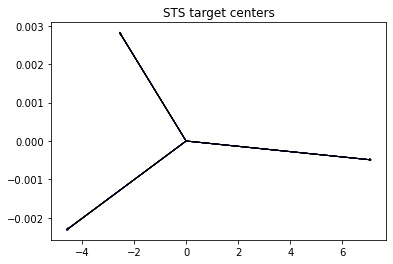

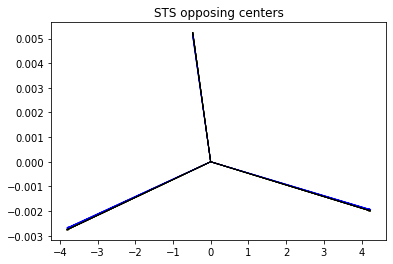

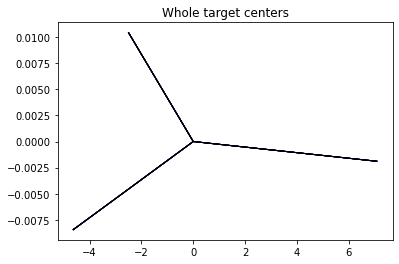

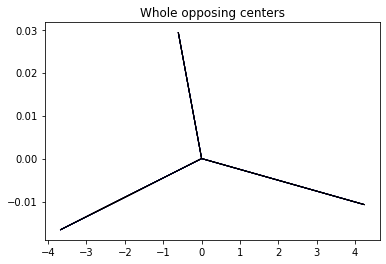

In [21]:
n = 1
r = 7

k = 3
w = 8

normalizers = ['none','zscore','snd','min-max']
cluster_algos = ['kmeans','agglo','gmm']
distance_metrics = ['eukl']
current_cluster_algo    = cluster_algos[0]
current_normalizer      = normalizers[1]
current_distance_metric = distance_metrics[0]
reduced_sampling_size   = True
dim_red                 = True
unify                   = True

target_ts = np_bitcoin_alltime
#opposing_ts = target_ts
opposing_ts = create_random_walk(target_ts, seed_)


meaningfulness_sts = 0
meaningfulness_whole = 0

sts_target_matrix = to_sts_matrix(target_ts, w)
sts_target_matrix = scale_feature_matrix(sts_target_matrix, current_normalizer)

sts_opposing_matrix = to_sts_matrix(opposing_ts, w)
sts_opposing_matrix = scale_feature_matrix(sts_opposing_matrix, current_normalizer)

whole_target_matrix = to_random_sampling_matrix(target_ts, w, reduced_sampling_size, seed_)
whole_target_matrix = scale_feature_matrix(whole_target_matrix, current_normalizer)

whole_opposing_matrix = to_random_sampling_matrix(opposing_ts, w, reduced_sampling_size, seed_)
whole_opposing_matrix = scale_feature_matrix(whole_opposing_matrix, current_normalizer)

## pca
if dim_red & w>8:
    sts_target_matrix = PCA(n_components='mle').fit_transform(sts_ts_matrix)
    whole_target_matrix = PCA(n_components='mle').fit_transform(whole_ts_matrix)
    sts_opposing_matrix = PCA(n_components='mle').fit_transform(sts_opposing_matrix)
    whole_opposing_matrix = PCA(n_components='mle').fit_transform(whole_opposing_matrix)

for _ in range(n):
    sts_target_centers = np.zeros((r,k,w))
    sts_opposing_centers = np.zeros((r,k,w))
    whole_target_centers = np.zeros((r,k,w))
    whole_opposing_centers = np.zeros((r,k,w))

    for i in range(r):
        sts_target_centers[i] = cluster_functions(sts_target_matrix,k,current_cluster_algo,unify)
        sts_opposing_centers[i] = cluster_functions(sts_opposing_matrix,k,current_cluster_algo,unify)
        whole_target_centers[i] = cluster_functions(whole_target_matrix,k,current_cluster_algo,unify)
        whole_opposing_centers[i] = cluster_functions(whole_opposing_matrix,k,current_cluster_algo,unify)

    meaningfulness_sts += clustering_meaningfulness(sts_target_centers, sts_opposing_centers, current_distance_metric)
    meaningfulness_whole += clustering_meaningfulness(whole_target_centers, whole_opposing_centers, current_distance_metric)

#print('--------------------------------------------------------------------------')    
#print('STS target centers:')
#print('')
#print(sts_target_centers)
#print('--------------------------------------------------------------------------')
#print('STS opposing centers:')
#print('')
#print(sts_opposing_centers)
#print('--------------------------------------------------------------------------')
#print('Whole target centers:')
#print('')
#print(whole_target_centers)
#print('--------------------------------------------------------------------------')
#print('Whole opposing centers:')
#print('')
#print(whole_opposing_centers)
#print('--------------------------------------------------------------------------')
#print('')
#print('sts meaning: '+str(meaningfulness_sts/n))
#print('whole meaning: '+str(meaningfulness_whole/n))



###### visualize ######
n_comp = 2

pca_sts_target_centers = np.zeros((r,k,n_comp))
pca_sts_opposing_centers = np.zeros((r,k,n_comp))
pca_whole_target_centers = np.zeros((r,k,n_comp))
pca_whole_opposing_centers = np.zeros((r,k,n_comp))

pca_sts_target_var = np.zeros((r,k,n_comp))
pca_sts_opposing_var = np.zeros((r,k,n_comp))
pca_whole_target_var = np.zeros((r,k,n_comp))
pca_whole_opposing_var = np.zeros((r,k,n_comp))
    
for i in range(r):
    pca_sts_target = PCA(n_components=n_comp).fit(sts_target_centers[i])
    pca_sts_opposing = PCA(n_components=n_comp).fit(sts_opposing_centers[i])
    pca_whole_target = PCA(n_components=n_comp).fit(whole_target_centers[i])
    pca_whole_opposing = PCA(n_components=n_comp).fit(whole_opposing_centers[i])
    
    pca_sts_target_var[i] = pca_sts_target.explained_variance_ratio_
    pca_sts_opposing_var[i] = pca_sts_opposing.explained_variance_ratio_
    pca_whole_target_var[i] = pca_whole_target.explained_variance_ratio_
    pca_whole_opposing_var[i] = pca_whole_opposing.explained_variance_ratio_
       
    pca_sts_target_centers[i] = PCA(n_components=n_comp).fit_transform(sts_target_centers[i])
    pca_sts_opposing_centers[i] = PCA(n_components=n_comp).fit_transform(sts_opposing_centers[i])
    pca_whole_target_centers[i] = PCA(n_components=n_comp).fit_transform(whole_target_centers[i])
    pca_whole_opposing_centers[i] = PCA(n_components=n_comp).fit_transform(whole_opposing_centers[i])

#print('--------------------------------------------------------------------------')    
#print('STS target centers:')
#print('')
#print(pca_sts_target_centers)
#print('____')
#print(pca_sts_target_var)
#print('--------------------------------------------------------------------------')
#print('STS opposing centers:')
#print('')
#print(pca_sts_opposing_centers)
#print('____')
#print(pca_sts_opposing_var)
#print('--------------------------------------------------------------------------')
#print('Whole target centers:')
#print('')
#print(pca_whole_target_centers)
#print('____')
#print(pca_whole_target_var)
#print('--------------------------------------------------------------------------')
#print('Whole opposing centers:')
#print('')
#print(pca_whole_opposing_centers)
#print('____')
#print(pca_whole_opposing_var)
#print('--------------------------------------------------------------------------')
#print('')



from mpl_toolkits.mplot3d import Axes3D

colors = ['yellow','magenta','cyan','red','green','blue','black']

for r in range(len(pca_sts_target_centers)):
    for v in pca_sts_target_centers[r]:
        plt.arrow(0,0,v[0],v[1],width = 0.00000001,head_length=0.05,head_width=0.00005,shape='full',  linestyle='-',color = colors[r])
plt.title('STS target centers')
plt.show()

for r in range(len(pca_sts_opposing_centers)):
    for v in pca_sts_opposing_centers[r]:
        plt.arrow(0,0,v[0],v[1],width = 0.00000001,head_length=0.05,head_width=0.00005,shape='full',  linestyle='-',color = colors[r])
plt.title('STS opposing centers')
plt.show()
        
for r in range(len(pca_whole_target_centers)):
    for v in pca_whole_target_centers[r]:
        plt.arrow(0,0,v[0],v[1],width = 0.00000001,head_length=0.05,head_width=0.00005,shape='full',  linestyle='-',color = colors[r])
plt.title('Whole target centers')
plt.show()
  
for r in range(len(pca_whole_opposing_centers)):
    for v in pca_whole_opposing_centers[r]:
        plt.arrow(0,0,v[0],v[1],width = 0.00000001,head_length=0.05,head_width=0.00005,shape='full',  linestyle='-',color = colors[r])
plt.title('Whole opposing centers')
plt.show()